### Data Dictionary

When selecting which stocks to invest in, investors seek to obtain good future returns. In this problem, we will first use clustering to identify clusters of stocks that have similar returns over time. Then, we'll use logistic regression to predict whether or not the stocks will have positive future returns.

For this problem, we'll use StocksCluster.csv, which contains monthly stock returns from the NASDAQ stock exchange. The NASDAQ is the second-largest stock exchange in the world, and it lists many technology companies. The stock price data used in this problem was obtained from infochimps, a website providing access to many datasets.

Each observation in the dataset is the monthly returns of a particular company in a particular year. The years included are 2000-2009. The companies are limited to tickers that were listed on the exchange for the entire period 2000-2009, and whose stock price never fell below $1. So, for example, one observation is for Yahoo in 2000, and another observation is for Yahoo in 2001. Our goal will be to predict whether or not the stock return in December will be positive, using the stock returns for the first 11 months of the year.

This dataset contains the following variables:

    ReturnJan = the return for the company's stock during January (in the year of the observation). 
    ReturnFeb = the return for the company's stock during February (in the year of the observation). 
    ReturnMar = the return for the company's stock during March (in the year of the observation). 
    ReturnApr = the return for the company's stock during April (in the year of the observation). 
    ReturnMay = the return for the company's stock during May (in the year of the observation). 
    ReturnJune = the return for the company's stock during June (in the year of the observation). 
    ReturnJuly = the return for the company's stock during July (in the year of the observation). 
    ReturnAug = the return for the company's stock during August (in the year of the observation). 
    ReturnSep = the return for the company's stock during September (in the year of the observation). 
    ReturnOct = the return for the company's stock during October (in the year of the observation). 
    ReturnNov = the return for the company's stock during November (in the year of the observation). 
    PositiveDec = whether or not the company's stock had a positive return in December (in the year of the observation). This variable takes value 1 if the return was positive, and value 0 if the return was not positive.

For the first 11 variables, the value stored is a proportional change in stock value during that month. For instance, a value of 0.05 means the stock increased in value 5% during the month, while a value of -0.02 means the stock decreased in value 2% during the month.

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import pickle
from pickle import dump, load

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import to_graphviz, plot_importance

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import _hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingRegressor

%matplotlib inline
sns.set_style('dark')
sns.set(font_scale=1.5)

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, mean_squared_error,r2_score
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, accuracy_score
from sklearn.metrics import auc, f1_score, precision_score, recall_score, roc_auc_score

import feature_engine.missing_data_imputers as mdi
from feature_engine.outlier_removers import Winsorizer

from tpot import TPOTClassifier, TPOTRegressor

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns= None
#pd.options.display.max_rows = None

### Data Exploration

In [2]:
df = pd.read_csv("StocksCluster.csv")

In [3]:
df

,ReturnJan,ReturnFeb,ReturnMar,ReturnApr,ReturnMay,ReturnJune,ReturnJuly,ReturnAug,ReturnSep,ReturnOct,ReturnNov,PositiveDec
0,0.080678,0.066250,0.032941,0.183099,0.130334,-0.017642,-0.020517,0.024676,-0.020408,-0.173318,-0.025385,0
1,-0.010680,0.102115,0.145496,-0.084428,-0.327300,-0.359266,-0.025321,0.211290,-0.580003,-0.267141,-0.151235,0
2,0.047742,0.035990,0.039702,-0.162353,-0.147427,0.048589,-0.135385,0.033392,0.000000,0.091696,-0.059561,0
3,-0.074040,-0.048170,0.018219,-0.024679,-0.006036,-0.025304,-0.094000,0.095290,0.056680,-0.096339,-0.040512,1
4,-0.031046,-0.212677,0.091476,0.189338,-0.153846,-0.106115,0.355301,0.056842,0.033602,0.036269,-0.085305,1
...,...,...,...,...,...,...,...,...,...,...,...,...
11575,-0.412598,-0.348853,0.080220,0.140919,0.264325,-0.202208,0.158703,0.270115,0.021023,-0.217680,-0.075896,0
11576,-0.153805,-0.140625,0.045124,0.318033,0.035736,0.134977,-0.056807,-0.029158,0.201563,-0.095903,0.263347,1
11577,-0.138686,-0.192090,0.229242,0.183735,0.232877,-0.029940,0.011213,-0.078140,0.141304,-0.153042,-0.004435,1
11578,-0.134111,-0.117148,0.705426,0.025229,0.258542,-0.011786,0.049180,-0.050687,0.034111,-0.226003,0.052995,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11580 entries, 0 to 11579
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ReturnJan    11580 non-null  float64
 1   ReturnFeb    11580 non-null  float64
 2   ReturnMar    11580 non-null  float64
 3   ReturnApr    11580 non-null  float64
 4   ReturnMay    11580 non-null  float64
 5   ReturnJune   11580 non-null  float64
 6   ReturnJuly   11580 non-null  float64
 7   ReturnAug    11580 non-null  float64
 8   ReturnSep    11580 non-null  float64
 9   ReturnOct    11580 non-null  float64
 10  ReturnNov    11580 non-null  float64
 11  PositiveDec  11580 non-null  int64  
dtypes: float64(11), int64(1)
memory usage: 1.1 MB


In [5]:
df.describe(include='all')

,ReturnJan,ReturnFeb,ReturnMar,ReturnApr,ReturnMay,ReturnJune,ReturnJuly,ReturnAug,ReturnSep,ReturnOct,ReturnNov,PositiveDec
count,11580.000000,11580.000000,11580.000000,11580.000000,11580.000000,11580.000000,11580.000000,11580.000000,11580.000000,11580.000000,11580.000000,11580.000000
mean,0.012632,-0.007605,0.019402,0.026308,0.024737,0.005938,0.003051,0.016198,-0.014721,0.005651,0.011387,0.546114
std,0.168993,0.188904,0.157727,0.167890,0.157943,0.157722,0.148054,0.129954,0.146712,0.175511,0.158079,0.497890
min,-0.761620,-0.690000,-0.712994,-0.826503,-0.922071,-0.717920,-0.761310,-0.726800,-0.839730,-0.685504,-0.747171,0.000000
25%,-0.069166,-0.077748,-0.046389,-0.054468,-0.046396,-0.063966,-0.073192,-0.046272,-0.074648,-0.070915,-0.054890,0.000000
50%,0.000996,-0.010626,0.009878,0.009059,0.012929,-0.000880,-0.000805,0.007205,-0.007616,0.002115,0.008522,1.000000
75%,0.073261,0.043600,0.077066,0.085338,0.083963,0.061566,0.071820,0.070783,0.049476,0.074542,0.076576,1.000000
max,3.068306,6.943694,4.008621,2.528827,6.930131,4.339713,2.550000,3.626609,5.863980,5.665138,3.271676,1.000000


In [6]:
df.shape

(11580, 12)

In [7]:
df.columns

Index(['ReturnJan', 'ReturnFeb', 'ReturnMar', 'ReturnApr', 'ReturnMay',
       'ReturnJune', 'ReturnJuly', 'ReturnAug', 'ReturnSep', 'ReturnOct',
       'ReturnNov', 'PositiveDec'],
      dtype='object')

### Data Visualization

### Univariate Data Exploration

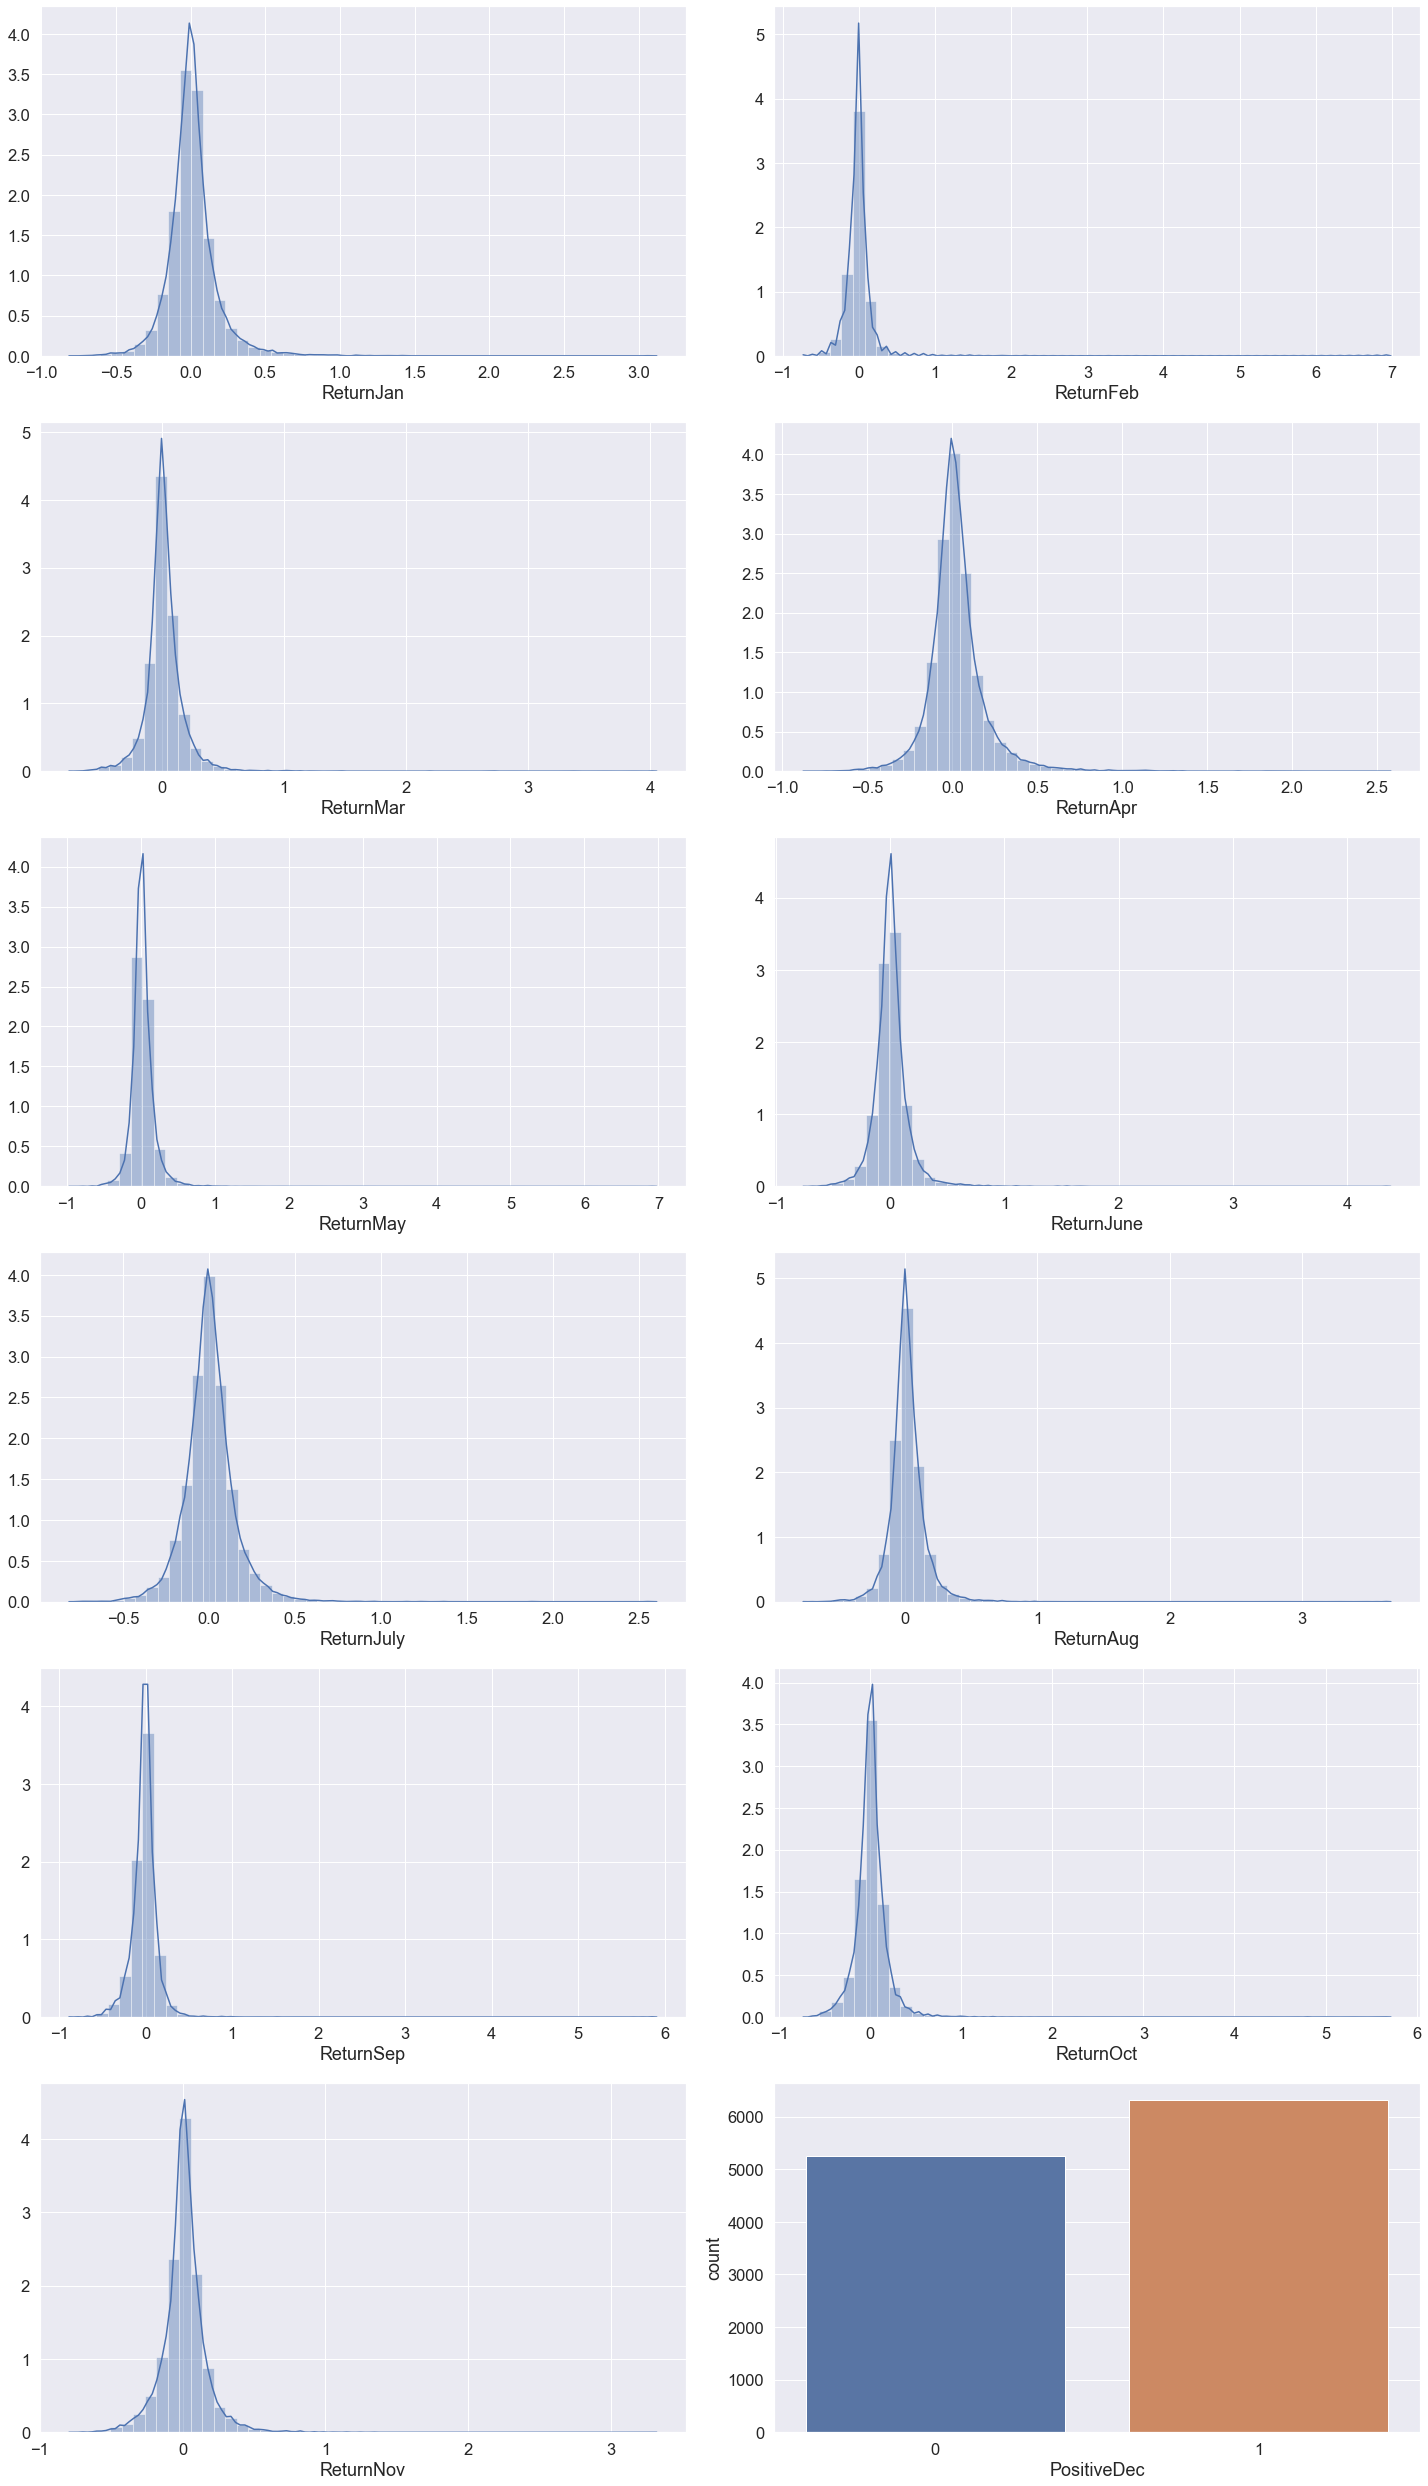

In [8]:
fig = plt.figure(figsize=(20,40))

plt.subplot(7,2,1)
sns.distplot(df.ReturnJan)
plt.subplot(7,2,2)
sns.distplot(df.ReturnFeb)
plt.subplot(7,2,3)
sns.distplot(df.ReturnMar)
plt.subplot(7,2,4)
sns.distplot(df.ReturnApr)
plt.subplot(7,2,5)
sns.distplot(df.ReturnMay)
plt.subplot(7,2,6)
sns.distplot(df.ReturnJune)
plt.subplot(7,2,7)
sns.distplot(df.ReturnJuly)
plt.subplot(7,2,8)
sns.distplot(df.ReturnAug)
plt.subplot(7,2,9)
sns.distplot(df.ReturnSep)
plt.subplot(7,2,10)
sns.distplot(df.ReturnOct)
plt.subplot(7,2,11)
sns.distplot(df.ReturnNov)
plt.subplot(7,2,12)
sns.countplot(df.PositiveDec)
# plt.subplot(7,2,13)
# sns.countplot()
# plt.subplot(7,2,14)
# sns.countplot()

plt.tight_layout()
plt.show()

### Bivariate Data Exploration

In [9]:
df.corr()

,ReturnJan,ReturnFeb,ReturnMar,ReturnApr,ReturnMay,ReturnJune,ReturnJuly,ReturnAug,ReturnSep,ReturnOct,ReturnNov,PositiveDec
ReturnJan,1.000000,0.066775,-0.090497,-0.037678,-0.044411,0.092238,-0.081430,-0.022792,-0.026437,0.142977,0.067632,0.004729
ReturnFeb,0.066775,1.000000,-0.155983,-0.191352,-0.095521,0.169994,-0.061779,0.131560,0.043502,-0.087324,-0.154658,-0.038173
ReturnMar,-0.090497,-0.155983,1.000000,0.009726,-0.003893,-0.085905,0.003374,-0.022005,0.076518,-0.011924,0.037324,0.022409
ReturnApr,-0.037678,-0.191352,0.009726,1.000000,0.063823,-0.011028,0.080632,-0.051756,-0.028921,0.048540,0.031762,0.094354
ReturnMay,-0.044411,-0.095521,-0.003893,0.063823,1.000000,-0.021075,0.090850,-0.033126,0.021963,0.017167,0.048047,0.058202
ReturnJune,0.092238,0.169994,-0.085905,-0.011028,-0.021075,1.000000,-0.029153,0.010711,0.044747,-0.022636,-0.065271,0.023410
ReturnJuly,-0.081430,-0.061779,0.003374,0.080632,0.090850,-0.029153,1.000000,0.000714,0.068948,-0.054709,-0.048374,0.074364
ReturnAug,-0.022792,0.131560,-0.022005,-0.051756,-0.033126,0.010711,0.000714,1.000000,0.000741,-0.075595,-0.116489,0.004167
ReturnSep,-0.026437,0.043502,0.076518,-0.028921,0.021963,0.044747,0.068948,0.000741,1.000000,-0.058079,-0.019720,0.041630
ReturnOct,0.142977,-0.087324,-0.011924,0.048540,0.017167,-0.022636,-0.054709,-0.075595,-0.058079,1.000000,0.191673,-0.052575


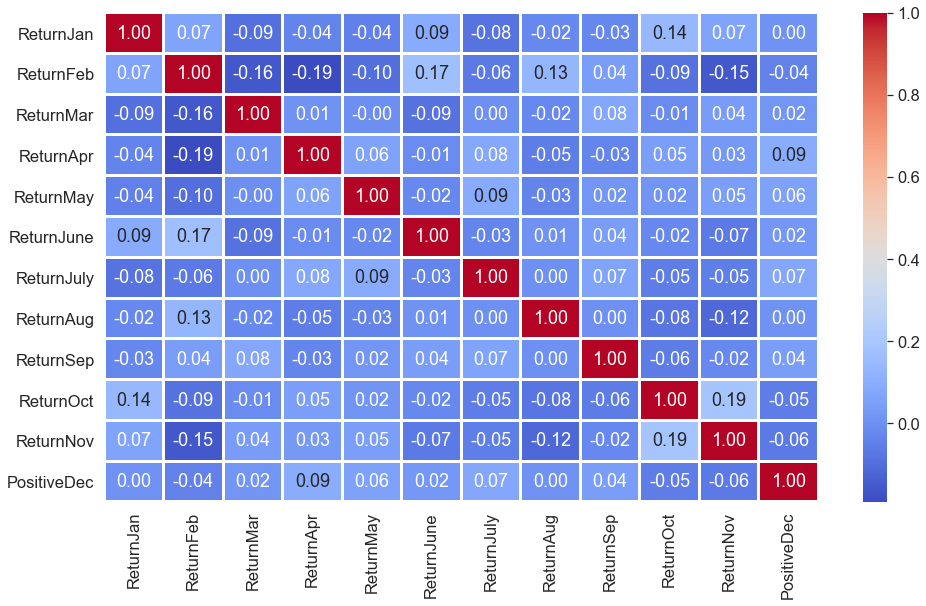

In [10]:
plt.figure(figsize=(16,9))
sns.heatmap(df.corr(),cmap="coolwarm",annot=True,fmt='.2f',linewidths=2)
plt.show()

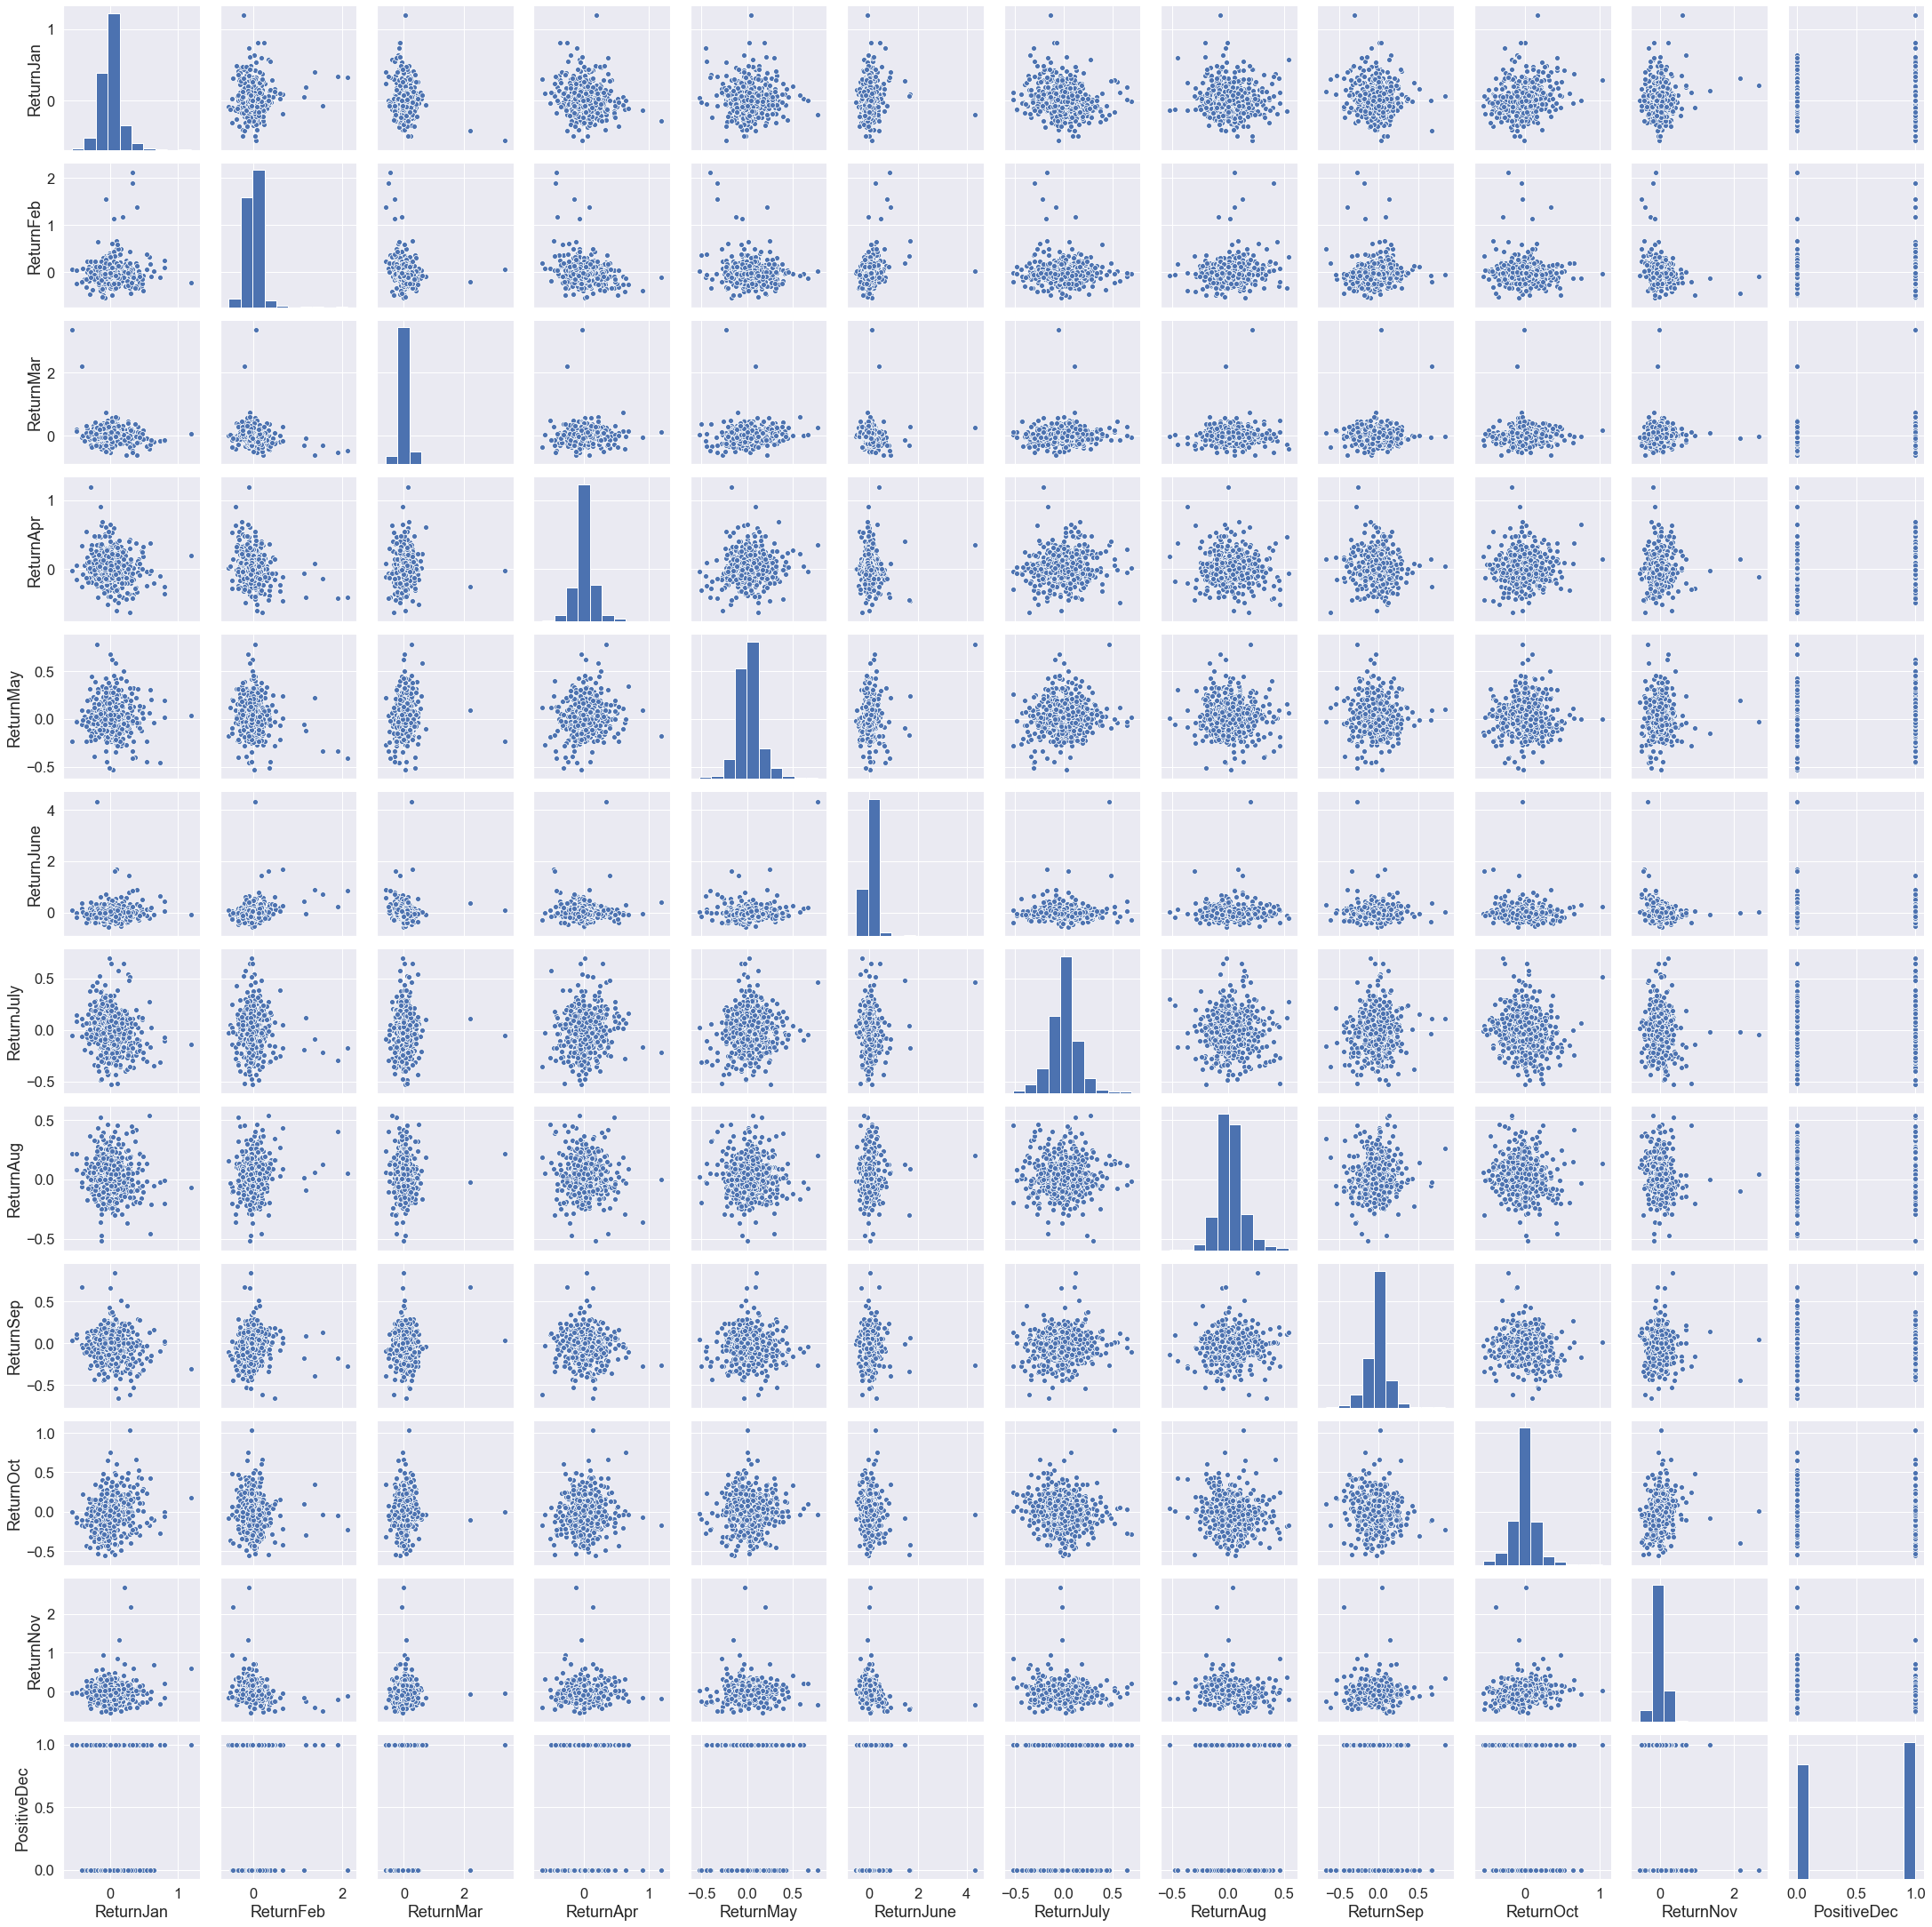

In [11]:
sns.pairplot(df.sample(1000))
plt.show()

### Data Preprocessing

### Treat Missing Values

In [12]:
df.isnull().sum()

ReturnJan      0
ReturnFeb      0
ReturnMar      0
ReturnApr      0
ReturnMay      0
ReturnJune     0
ReturnJuly     0
ReturnAug      0
ReturnSep      0
ReturnOct      0
ReturnNov      0
PositiveDec    0
dtype: int64

### Treat Duplicate Values

In [13]:
df.duplicated(keep='first').sum()

29

### Treat Imbalance Data

### Treat Outliers

### Treat Data Types

### Drop unwanted features

### Create and save processed dataset

In [14]:
df.shape

(11580, 12)

### Train Test Split

In [15]:
X = df.iloc[:,0:11]
y = df.iloc[:,11]

In [16]:
X.values, y.values

(array([[ 0.08067797,  0.06625   ,  0.03294118, ..., -0.02040816,
         -0.17331768, -0.02538531],
        [-0.01067989,  0.10211539,  0.14549595, ..., -0.58000326,
         -0.26714125, -0.15123457],
        [ 0.04774193,  0.03598972,  0.03970223, ...,  0.        ,
          0.0916955 , -0.05956113],
        ...,
        [-0.13868613, -0.1920904 ,  0.22924188, ...,  0.14130435,
         -0.15304183, -0.00443459],
        [-0.13411079, -0.11714771,  0.70542636, ...,  0.03411131,
         -0.22600349,  0.05299539],
        [ 1.43589744, -0.235     , -0.04109589, ...,  0.22772277,
         -0.022     , -0.04123711]]),
 array([0, 0, 0, ..., 1, 1, 0], dtype=int64))

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [18]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9264, 11), (2316, 11), (9264,), (2316,))

### Feature Scaling

### Model Training

### Using XGBoost

In [19]:
xgbmodel = XGBClassifier(random_state=0, n_estimators=100, objective='binary:logistic')

In [20]:
xgbmodel.fit(X_train,y_train,eval_set=[(X_test,y_test)],eval_metric='error',early_stopping_rounds=10)

[0]	validation_0-error:0.457686
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.44905
[2]	validation_0-error:0.451641
[3]	validation_0-error:0.436529
[4]	validation_0-error:0.430915
[5]	validation_0-error:0.433938
[6]	validation_0-error:0.435233
[7]	validation_0-error:0.428325
[8]	validation_0-error:0.427461
[9]	validation_0-error:0.43437
[10]	validation_0-error:0.433938
[11]	validation_0-error:0.429188
[12]	validation_0-error:0.429188
[13]	validation_0-error:0.428756
[14]	validation_0-error:0.431347
[15]	validation_0-error:0.428756
[16]	validation_0-error:0.429188
[17]	validation_0-error:0.431779
[18]	validation_0-error:0.423575
[19]	validation_0-error:0.427893
[20]	validation_0-error:0.42962
[21]	validation_0-error:0.430915
[22]	validation_0-error:0.427029
[23]	validation_0-error:0.426166
[24]	validation_0-error:0.427893
[25]	validation_0-error:0.431347
[26]	validation_0-error:0.431779
[27]	validation_0-error:0.42962
[28]	validation_0-error:

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [21]:
y_pred = xgbmodel.predict(X_test)

In [22]:
y_pred

array([1, 1, 0, ..., 1, 0, 0], dtype=int64)

### Model Evaluation

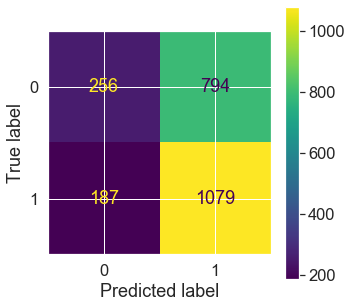

In [23]:
fig , ax = plt.subplots(figsize=(5,5))
plot_confusion_matrix(xgbmodel,X_test,y_test,values_format='.4g',ax=ax)
plt.show()

In [24]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.58      0.24      0.34      1050
           1       0.58      0.85      0.69      1266

    accuracy                           0.58      2316
   macro avg       0.58      0.55      0.52      2316
weighted avg       0.58      0.58      0.53      2316



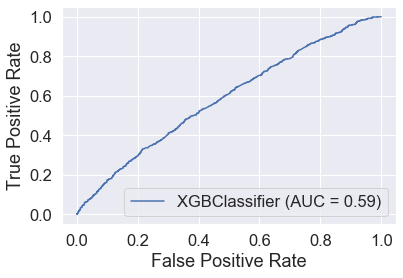

In [25]:
plot_roc_curve(xgbmodel,X_test,y_test)
plt.show()

### Available importance_types = [‘weight’, ‘gain’, ‘cover’, ‘total_gain’, ‘total_cover’]

In [26]:
X.columns

Index(['ReturnJan', 'ReturnFeb', 'ReturnMar', 'ReturnApr', 'ReturnMay',
       'ReturnJune', 'ReturnJuly', 'ReturnAug', 'ReturnSep', 'ReturnOct',
       'ReturnNov'],
      dtype='object')

In [27]:
xgbmodel.get_booster().feature_names = ['ReturnJan', 'ReturnFeb', 'ReturnMar', 'ReturnApr', 'ReturnMay',
       'ReturnJune', 'ReturnJuly', 'ReturnAug', 'ReturnSep', 'ReturnOct',
       'ReturnNov']

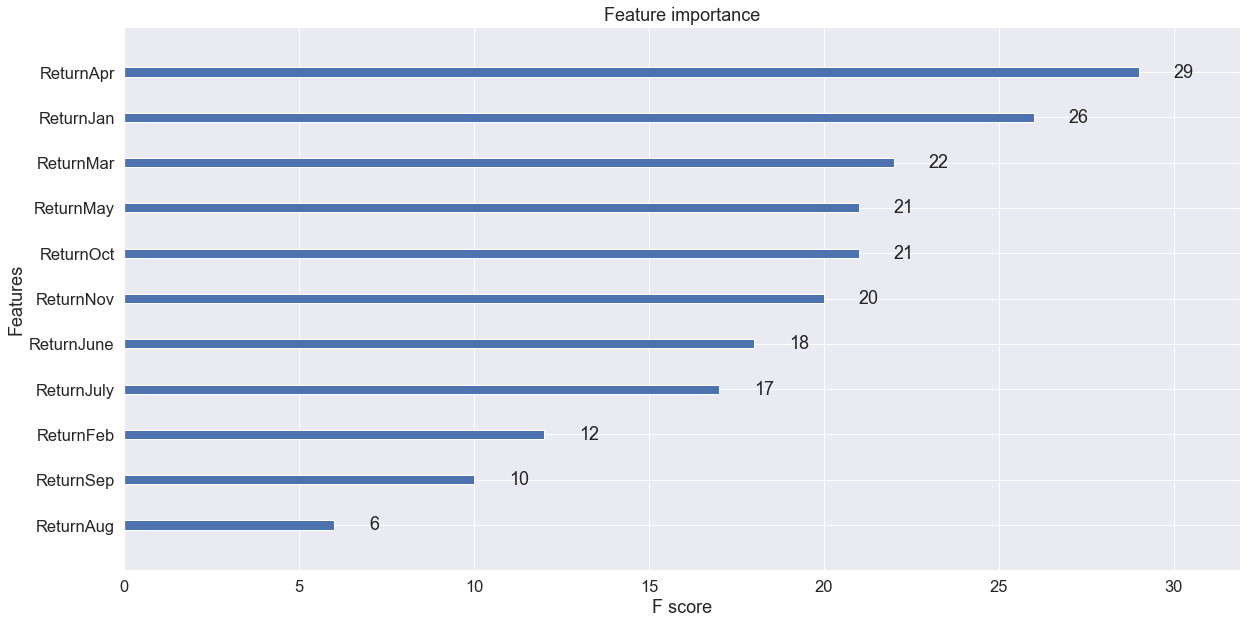

In [28]:
fig, ax = plt.subplots(figsize=(20,10))
xgb.plot_importance(xgbmodel.get_booster(),ax=ax)
plt.show()

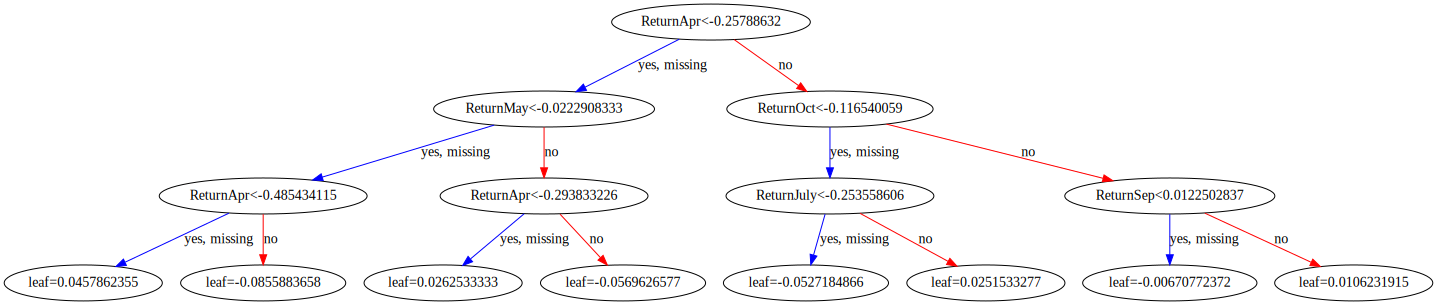

In [29]:
xgb.to_graphviz(xgbmodel,num_trees=20)

Example:

f = 'gain'

XGBClassifier.get_booster().get_score(importance_type= f)

### Cross-Validation

In [30]:
cv = cross_val_score(xgbmodel,X,y,cv=5,verbose=1,scoring='accuracy')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.7s finished


In [31]:
cv.mean()

0.5434369602763385

### Save the Model

In [32]:
filename = 'stockreturnmodel.sav'
dump(xgbmodel,open(filename,'wb'))

### Load the Model

In [33]:
loaded_model = load(open(filename,'rb'))

In [34]:
loaded_model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)